## CRBM

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from time import time

from crbm.rbm import CRBM
# Import our RBM
from crbm.rbm import CRBM

In [3]:
# Function for reading data file
import struct
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

In [4]:
X_test = read_idx("data/MNIST/raw/t10k-images-idx3-ubyte").reshape(-1, 28*28)
X = read_idx("data/MNIST/raw/train-images-idx3-ubyte").reshape(-1, 28*28)
y_test = read_idx("data/MNIST/raw/t10k-labels-idx1-ubyte")
y = read_idx("data/MNIST/raw/train-labels-idx1-ubyte")

# EXTREMELY IMPORTANT TO NORMALIZE
X = np.true_divide(X, 255)
X_test = np.true_divide(X_test, 255)

In [5]:
# Some hand picked images for each class for plotting
selected_imgs = X[[1, 6, 5, 12, 26, 35, 62, 52, 46, 4]]

In [6]:
# Train-val split
split = 0.1
indices = np.arange(len(X))
np.random.shuffle(indices)
X_val = X[:int(split*X.shape[0])]
X_train = X[int(split*X.shape[0]):]
y_val = y[:int(split*X.shape[0])]
y_train = y[int(split*X.shape[0]):]
print("Number of training instances:\t", y_train.shape[0])
print("Number of validation instances:\t", y_val.shape[0])
print("Number of test instances:\t", y_test.shape[0])

Number of training instances:	 54000
Number of validation instances:	 6000
Number of test instances:	 10000


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
print("Number of training instances:\t", y_train.shape[0])
print("Number of validation instances:\t", y_val.shape[0])
print("Number of test instances:\t", y_test.shape[0])

Number of training instances:	 54000
Number of validation instances:	 6000
Number of test instances:	 10000


In [8]:
def KL(P, Q):
    epsilon = 1e-10
    P = np.clip(P, epsilon, 1)
    Q = np.clip(Q, epsilon, 1)
    return np.sum(P * np.log(P / Q))


In [9]:
def get_batches(data, batch_size, shuffle=False):
    '''
    Function to provide data in batches.
    input:
        - data: The data to be batched, each sample in one row.
        - batch_size: Size of one batch (last batch might be smaller)
        - shuffle: True if data should be shuffled.
    '''
    if(shuffle):
        np.random.shuffle(data)
    if(batch_size == -1):
        batch_size = len(data)
    num_batches = math.ceil(data.shape[0]/batch_size)
    for batch_num in range(num_batches):
        yield data[batch_num*batch_size:(batch_num+1)*batch_size]

In [10]:
# Some parameters to set
batch_size = 50
num_epochs = 100
lr = 0.1
burn_in = 0
num_steps = 1

In [99]:
model = CRBM(v_dim=X_train.shape[-1], h_dim=100)

In [100]:
crbm_dkl_per_epoch = []

In [101]:
from time import time
import torch
# Training loop
errors = []
free_energies_val = []
free_energies_train = []
start_time = time()

for epoch in range(1, num_epochs+1):
    iteration = 0
    error = 0
    for batch in get_batches(X_train, batch_size, shuffle=True):
        iteration += 1
   
        # Compute gradients and errors
        error += model.compute_grad(batch)
        
        # Update parameters - use momentum as explained in Hinton's guide
        if(epoch > 5):
            model.update(lr, momentum=0.5)
        else:
            model.update(lr, momentum=0.9)
        
    #plot_images(rbm, selected_imgs, 
    #        title="Reconstructed Images    Epoch: {}".format(epoch),
    #        save_as="recon_" + str(epoch))
        
    print("epoch:{} \t error:{:.4f} \t training time:{:.2f} s".format(epoch, error, time()-start_time))
    errors.append(error)
    # Calcul du DKL sur 100 images de validation
    
    # == Calcule DKL pour le CRBM à chaque époque ==
    dkl_values = []
    num_samples = 10  # ou plus selon les ressources
    
    with torch.no_grad():
        for i in range(num_samples):
            img = X_val[i].reshape(-1)  # Assure-toi que X_val est bien défini
            img_resized = img.reshape(28, 28).flatten()

    
            # Normalisation
            img_rescaled = img_resized / np.max(img_resized) if np.max(img_resized) > 0 else img_resized
            recon = model.get_reconstruction(img_rescaled)
    
            # Empêche division par zéro
            P = recon / np.sum(recon) if np.sum(recon) > 0 else np.ones_like(recon) / len(recon)
            Q = img_rescaled / np.sum(img_rescaled) if np.sum(img_rescaled) > 0 else np.ones_like(img_rescaled) / len(img_rescaled)
    
            dkl = KL(P, Q)
            dkl_values.append(dkl)
    
    mean_dkl = np.mean(dkl_values)
    crbm_dkl_per_epoch.append(mean_dkl)
    print(f"Epoch {epoch} - Mean DKL: {mean_dkl:.4f}")


epoch:1 	 error:38137.4930 	 training time:10.90 s
Epoch 1 - Mean DKL: 1.4427
epoch:2 	 error:23962.1405 	 training time:24.72 s
Epoch 2 - Mean DKL: 1.2257
epoch:3 	 error:22117.6279 	 training time:35.25 s
Epoch 3 - Mean DKL: 1.0859
epoch:4 	 error:21222.9793 	 training time:45.64 s
Epoch 4 - Mean DKL: 1.0293
epoch:5 	 error:20667.6262 	 training time:56.07 s
Epoch 5 - Mean DKL: 0.9692
epoch:6 	 error:20302.9280 	 training time:67.81 s
Epoch 6 - Mean DKL: 0.9365
epoch:7 	 error:20019.9027 	 training time:80.49 s
Epoch 7 - Mean DKL: 0.9161
epoch:8 	 error:19778.6540 	 training time:93.73 s
Epoch 8 - Mean DKL: 0.8848
epoch:9 	 error:19582.4121 	 training time:106.14 s
Epoch 9 - Mean DKL: 0.8953
epoch:10 	 error:19427.9521 	 training time:120.65 s
Epoch 10 - Mean DKL: 0.8686
epoch:11 	 error:19277.6335 	 training time:133.05 s
Epoch 11 - Mean DKL: 0.8895
epoch:12 	 error:19133.4724 	 training time:145.66 s
Epoch 12 - Mean DKL: 0.8248
epoch:13 	 error:19046.5417 	 training time:162.30 s
E

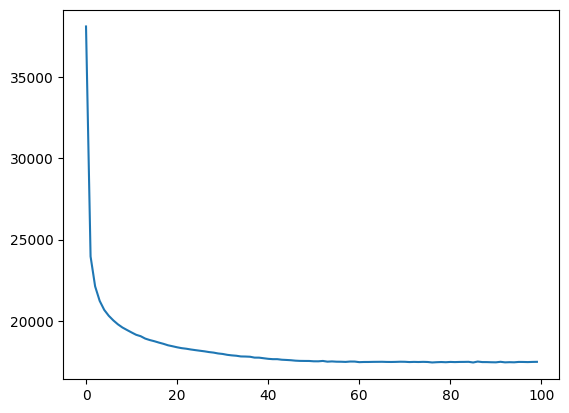

In [102]:
# plotting energy
plt.plot(errors)
plt.savefig("error_plot")

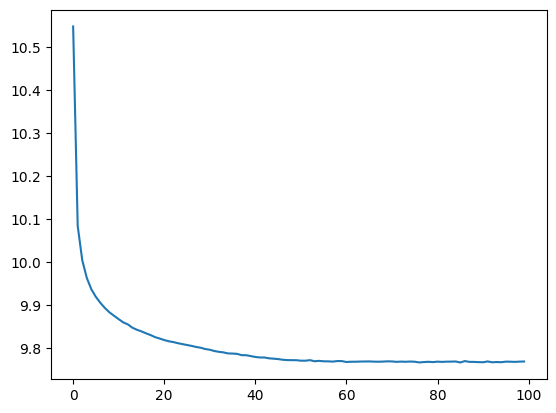

In [103]:
# plotting energy
plt.plot(np.log(np.array(errors)))
plt.savefig("error_plot")

<Figure size 640x480 with 0 Axes>

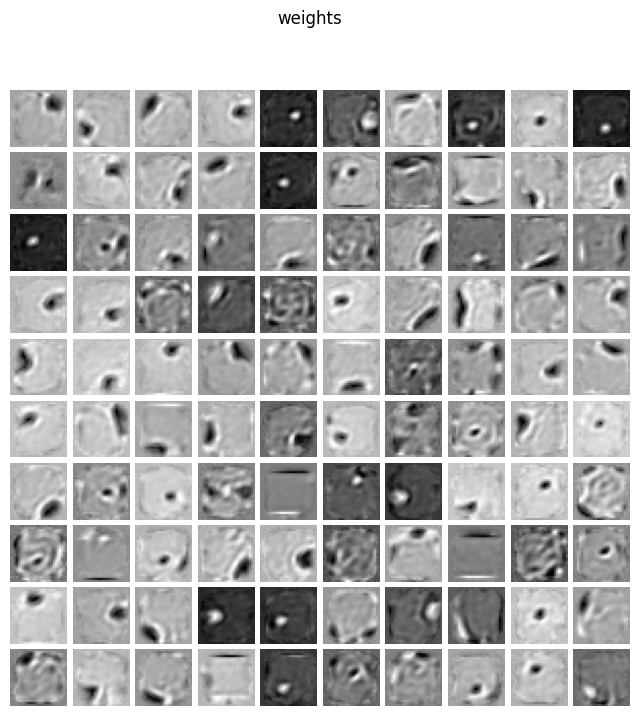

In [104]:
plt.clf()
title="weights"
fig, axes = plt.subplots(10, 10, gridspec_kw = {'wspace':0.1, 'hspace':0.1}, figsize=(8, 8))
fig.suptitle(title)
for i in range(10):
    for j in range(10):
        axes[i, j].imshow(model.W[:,i*10+j].reshape(28, 28), cmap='gray')
        axes[i, j].axis('off')
        
plt.savefig("weights")
plt.show()
plt.close()

<Figure size 640x480 with 0 Axes>

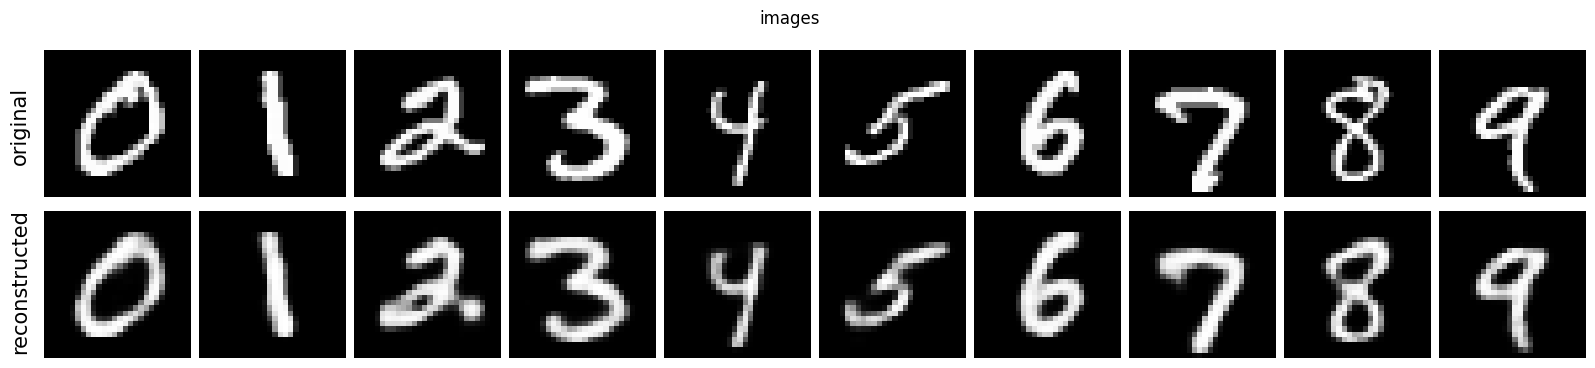

In [105]:
images = selected_imgs
num_samples = len(selected_imgs)
plt.clf()
fig, axes = plt.subplots(2, num_samples, gridspec_kw = {'wspace':0, 'hspace':0.1}, figsize=(2*num_samples, 4))
fig.suptitle("images")
text = axes[0, 0].text(-7, 14,"original", size=15,
                       verticalalignment='center', rotation=-270)
text = axes[1, 0].text(-7, 13,"reconstructed", size=15,
                       verticalalignment='center', rotation=-270)
for n in range(num_samples):
    axes[0, n].imshow(images[n].reshape(28, 28), cmap='gray')
    axes[1, n].imshow(model.get_reconstruction(images[n].reshape(28*28)).reshape(28, 28), cmap='gray')
    axes[0, n].axis('off')
    axes[1, n].axis('off')
plt.savefig("reconstructed")
plt.show()
plt.close()

## VAE

In [106]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision.utils import save_image
import cv2
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


#### Downloading the dataset

In [107]:
trainset = torchvision.datasets.MNIST(root='./data', train = True, download = True, transform = transforms.ToTensor())
testset = torchvision.datasets.MNIST(root='./data', train = False, download = True, transform = transforms.ToTensor())
xtrain = trainset.data.numpy()
ytrain = trainset.targets.numpy()
x_val_pre = testset.data[:1000].numpy()
y_val = testset.targets[:1000].numpy()

### Creating x_train and y_train with 1000 images from each class and binarizing the pixels

In [108]:
count = np.zeros(10)
idx = []
for i in range(0, len(ytrain)):
  for j in range(10):
    if(ytrain[i] == j):
      count[j] += 1
      if(count[j]<=1000):
        idx = np.append(idx, i)
        
y_train = ytrain[idx.astype('int')]
x_train_pre = xtrain[idx.astype('int')]

### Resizing the images from 28x28 to 14x14

In [109]:
r,_,_ = x_train_pre.shape
x_train = np.zeros([r,14,14])
for i in range(r):
  a = cv2.resize(x_train_pre[i].astype('float32'), (14,14)) # Resizing the image from 28*28 to 14*14
  x_train[i] = a

r,_,_ = x_val_pre.shape
x_val = np.zeros([r,14,14])
for i in range(r):
  a = cv2.resize(x_val_pre[i].astype('float32'), (14,14)) # Resizing the image from 28*28 to 14*14
  x_val[i] = a

### Binarizing 

In [110]:
x_train = np.where(x_train > 128, 1, 0)
x_val = np.where(x_val > 128, 1, 0)
x_train = x_train.astype(np.float32)
x_val = x_val.astype(np.float32)

### Creating dataloaders

In [111]:
batch_size = 32
trainloader = torch.utils.data.DataLoader([[x_train[i], y_train[i]] for i in range(len(y_train))], shuffle=True, batch_size=batch_size)
testloader = torch.utils.data.DataLoader([[x_val[i], y_val[i]] for i in range(len(y_val))], shuffle=True, batch_size=100)

### Variational Auto Encoder model

In [112]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(196, 128) #Encoder
        self.fc21 = nn.Linear(128, 8) #mu
        self.fc22 = nn.Linear(128, 8) #sigma

        self.fc3 = nn.Linear(8, 128) #Decoder
        self.fc4 = nn.Linear(128, 196)
        
    def encoder(self, x):
        h = torch.tanh(self.fc1(x))
        return self.fc21(h), self.fc22(h) # mu, std
    
    def sampling(self, mu, std): # Reparameterization trick
        eps1 = torch.randn_like(std)
        eps2 = torch.randn_like(std)
        return 0.5*((eps1 * std + mu) + (eps2 * std + mu)) # Using two samples to compute expectation over z

    def decoder(self, z):
        h = torch.tanh(self.fc3(z))
        return torch.sigmoid(self.fc4(h)) 
    
    def forward(self, x):
        mu, std = self.encoder(x.view(-1, 196))
        z = self.sampling(mu, std)
        return self.decoder(z), mu, std
vae_model = VAE()
if torch.cuda.is_available():
    vae_model.cuda()

### Defining loss, optimizer and LR scheduler

In [113]:
optimizer = torch.optim.Adam(vae_model.parameters(), lr = 0.002)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.5, 
                             patience=5, threshold=0.001, cooldown=0,
                             min_lr=0.0001)

def loss_function(y, x, mu, std): 
    ERR = F.binary_cross_entropy(y, x.view(-1, 196), reduction='sum')
    KLD = -0.5 * torch.sum(1 + torch.log(std**2) - mu**2 - std**2)
    return ERR + KLD, -ERR, -KLD

### Training and Validating

In [114]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae_model.to(device)
count=0
err_l, kld_l, n_wu, testl, update = [], [], [], [], []
for epoch in range(1, 100):
    
    train_loss = 0
    for batch_idx, (data, _) in enumerate(trainloader):
        vae_model.train()
        data = data.to(device)
        bsize = data.shape[0]
        recon_batch, mu, std = vae_model(data)
        loss, err, kld = loss_function(recon_batch, data, mu, std)
        loss.backward()
        train_loss += err.item() + kld.item()
        optimizer.step()
        optimizer.zero_grad()
        err_l.append(err.item()/bsize)
        kld_l.append(kld.item()/bsize)
        count+=1
        n_wu.append(count)

        if (count%100 == 0): # Validating every 100 weight updates
          vae_model.eval()
          a, _ = next(iter(testloader))
          a = a.to(device)
          trecon, tmu, tstd = vae_model(a)
          tloss, terr, tkld = loss_function(trecon, a, tmu, tstd)
          testl.append(terr/100)
          update.append(count)

    scheduler.step(train_loss / len(trainloader.dataset))
    
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(trainloader.dataset)))
    vae_model.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in testloader:
            data = data.to(device)
            recon, mu, std =vae_model(data)
            loss, err, kld = loss_function(recon, data, mu, std)
            test_loss += err + kld
    
    test_loss /= len(testloader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

====> Epoch: 1 Average loss: -52.2766
====> Test set loss: -41.8722
====> Epoch: 2 Average loss: -39.9399
====> Test set loss: -38.1934
====> Epoch: 3 Average loss: -37.4952
====> Test set loss: -36.8069
====> Epoch: 4 Average loss: -36.4924
====> Test set loss: -36.0444
====> Epoch: 5 Average loss: -35.7916
====> Test set loss: -35.5609
====> Epoch: 6 Average loss: -35.2579
====> Test set loss: -35.3097
====> Epoch: 7 Average loss: -34.8183
====> Test set loss: -34.8269
====> Epoch: 8 Average loss: -34.3836
====> Test set loss: -34.4325
====> Epoch: 9 Average loss: -34.1396
====> Test set loss: -34.3162
====> Epoch: 10 Average loss: -33.8469
====> Test set loss: -33.8821
====> Epoch: 11 Average loss: -33.6772
====> Test set loss: -33.9158
====> Epoch: 12 Average loss: -33.4137
====> Test set loss: -33.7415
====> Epoch: 13 Average loss: -33.2726
====> Test set loss: -33.6413
====> Epoch: 14 Average loss: -33.0734
====> Test set loss: -33.5132
====> Epoch: 15 Average loss: -32.9350
====

In [115]:
(kld_l[::60])

[-17.298967361450195,
 -2.377103567123413,
 -2.608246326446533,
 -3.1305794715881348,
 -3.7604498863220215,
 -4.14865255355835,
 -4.59820032119751,
 -4.854983329772949,
 -4.6170172691345215,
 -4.992763042449951,
 -4.735485553741455,
 -5.2684736251831055,
 -5.032470226287842,
 -5.457083702087402,
 -5.6599016189575195,
 -5.2107672691345215,
 -5.481722831726074,
 -5.8702216148376465,
 -5.247443675994873,
 -5.617749214172363,
 -6.743961334228516,
 -5.714948654174805,
 -5.981090068817139,
 -5.993541717529297,
 -5.541040420532227,
 -6.2667412757873535,
 -6.025907516479492,
 -6.082305908203125,
 -5.883393287658691,
 -6.035434246063232,
 -6.007424354553223,
 -6.0426530838012695,
 -6.352788925170898,
 -5.988531112670898,
 -5.9438652992248535,
 -6.115437984466553,
 -6.116868495941162,
 -5.5280890464782715,
 -6.019022464752197,
 -6.924169063568115,
 -6.370879173278809,
 -6.19670295715332,
 -6.9538044929504395,
 -5.973567008972168,
 -6.235809326171875,
 -6.341316223144531,
 -6.406370162963867,
 -6

### (iii) Plotting the first and second term of ELBO as a function of weight updates

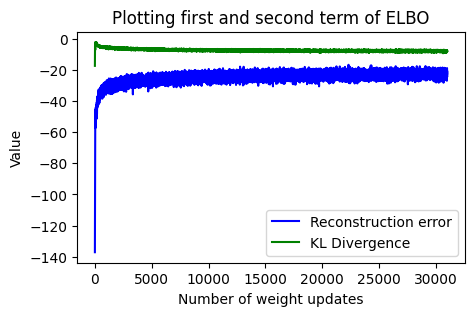

In [116]:
plt.figure(figsize=(5,3), dpi=100)
plt.plot(n_wu, err_l, 'b', label='Reconstruction error')
plt.plot(n_wu, kld_l, 'g', label='KL Divergence')
plt.title('Plotting first and second term of ELBO')
plt.xlabel('Number of weight updates')
plt.ylabel('Value')
plt.legend()

### Visualizing input and output from the VAE from training set

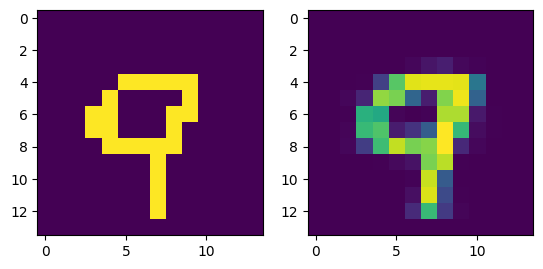

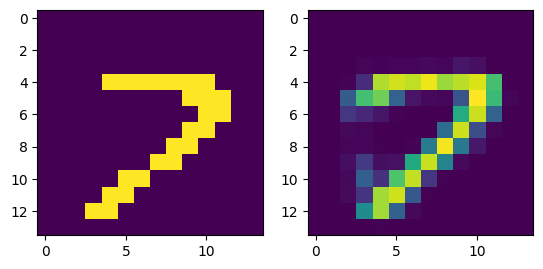

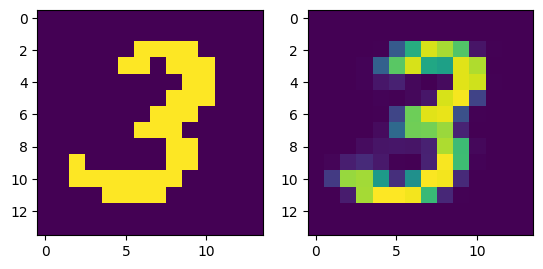

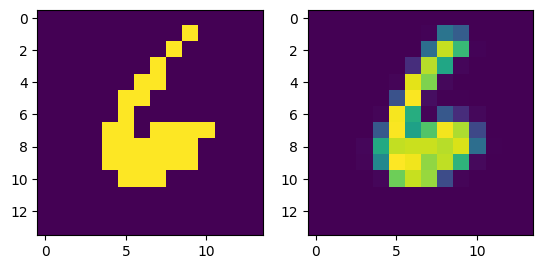

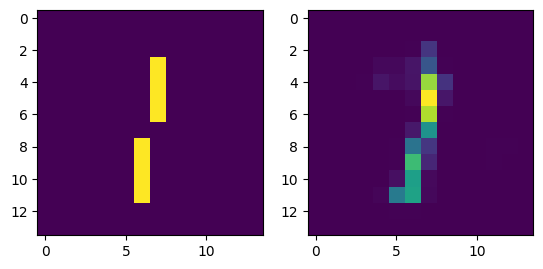

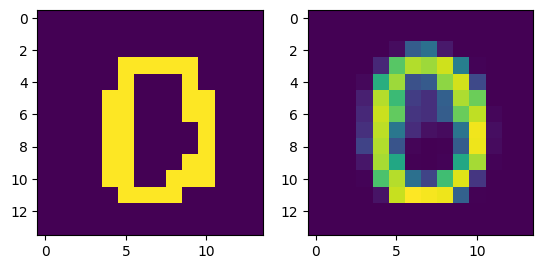

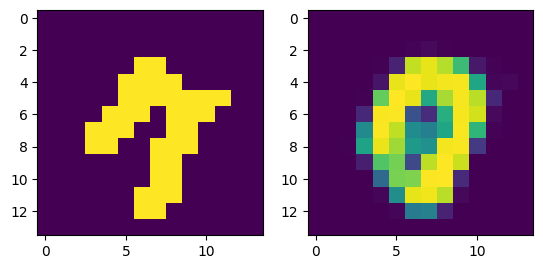

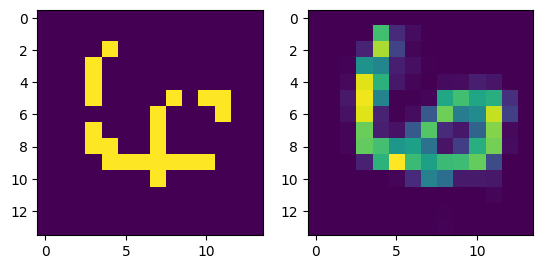

In [117]:
vae_model.eval()
for i in range(8):
  a,t = next(iter(trainloader))
  a = a.to(device)
  recon, mu, std = vae_model(a[0])
  b = recon[0].reshape((14,14))
  f, axarr = plt.subplots(1,2)
  axarr[0].imshow(a[0].detach().cpu().numpy())
  axarr[1].imshow(b.detach().cpu().numpy())

### Visualizing input and output of the VAE from validation set

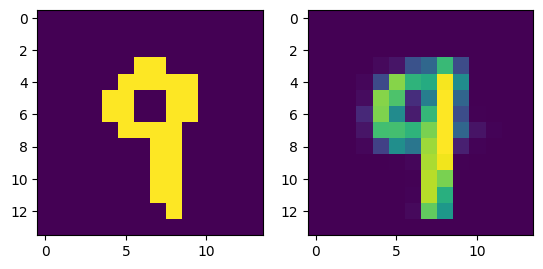

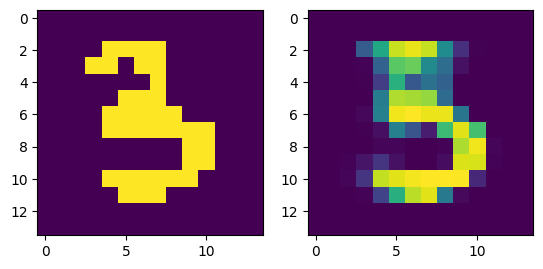

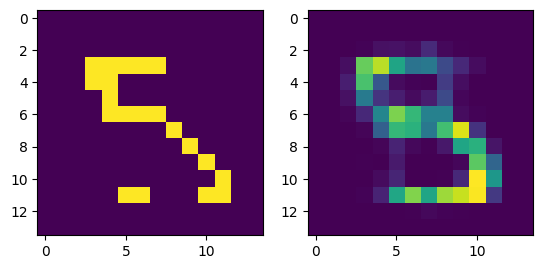

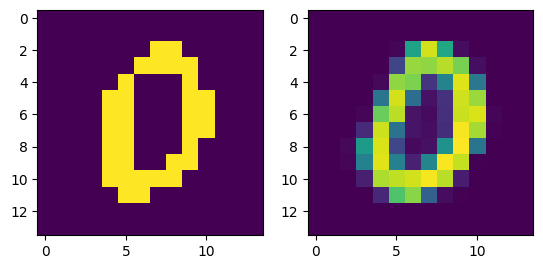

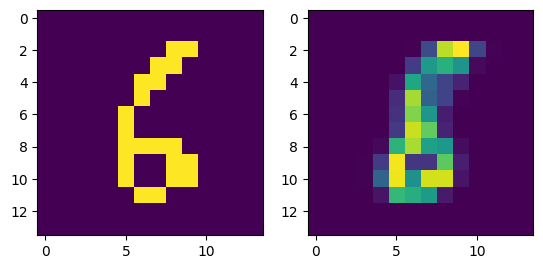

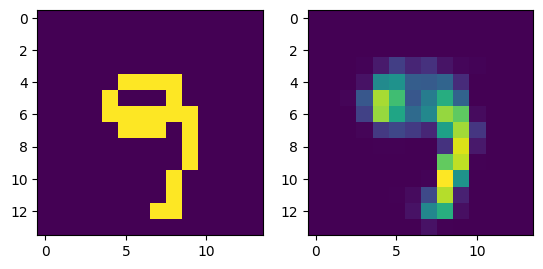

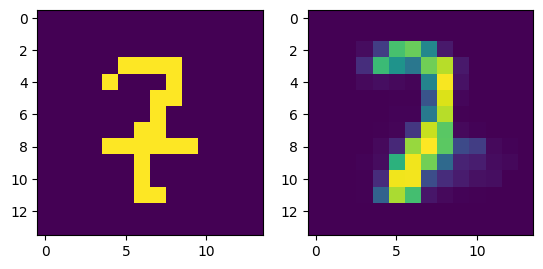

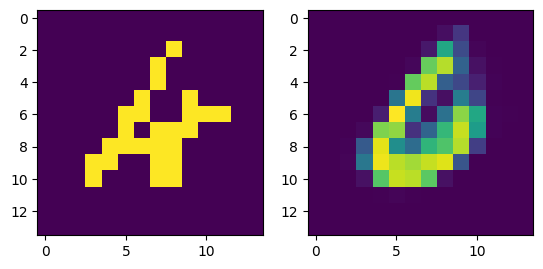

In [118]:
vae_model.eval()
for i in range(8):
  a,t = next(iter(testloader))
  a = a.to(device)
  recon, mu, std = vae_model(a[0])
  b = recon[0].reshape((14,14))
  f, axarr = plt.subplots(1,2)
  axarr[0].imshow(a[0].detach().cpu().numpy())
  axarr[1].imshow(b.detach().cpu().numpy())

### Synthesizing MNIST images from a Standard Gaussian Distribution

tensor([-0.2166, -0.1178,  0.8020,  0.4344, -0.8301, -0.7181,  1.1271,  0.9757])
tensor([-1.7966,  0.4650, -0.0705, -0.2957, -0.4192, -0.9291, -0.6874, -0.8055])
tensor([ 2.4639, -0.7242, -0.1994,  0.8745, -1.1502,  0.4824,  0.4162,  0.2110])
tensor([ 0.2860, -0.5891, -1.5321,  0.1834, -1.7958,  1.6088, -1.0501, -0.0865])
tensor([-0.1869, -1.4472, -1.6345, -0.6973, -0.9263, -0.3661,  0.8003,  1.0680])
tensor([-0.0731,  0.5857, -1.3272, -0.9159,  1.6573, -0.8585,  0.1583, -0.9489])
tensor([-1.9806, -1.5059,  0.2158,  0.5960,  0.3130, -0.3399, -0.0211, -0.1138])
tensor([ 2.3772,  1.1732, -1.8633, -0.5562,  0.0644, -0.3701, -0.6343,  0.2616])


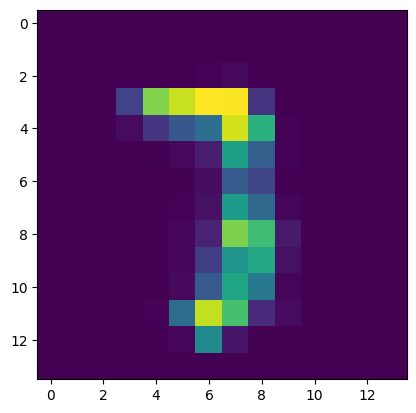

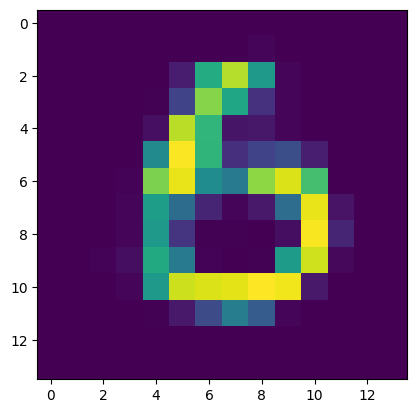

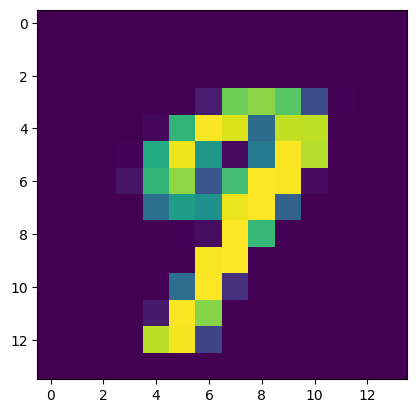

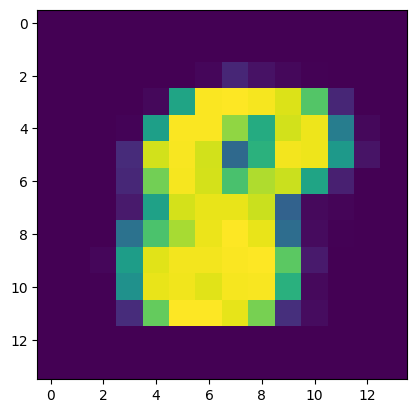

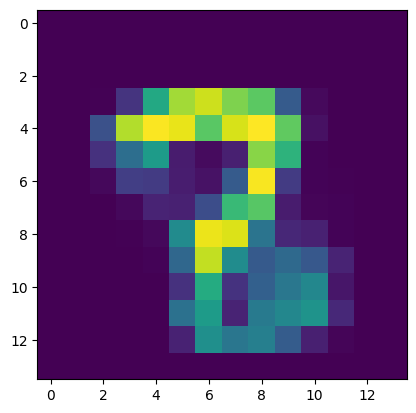

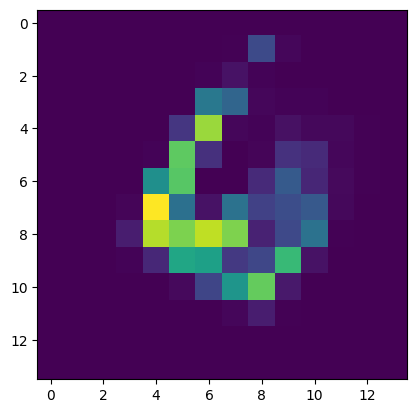

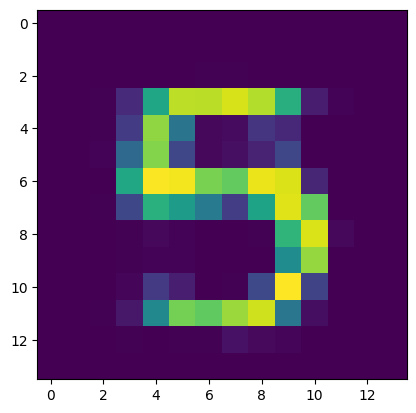

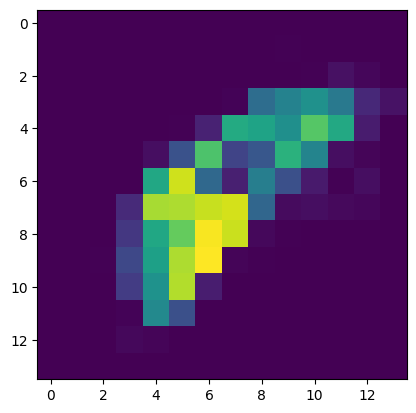

In [119]:
for i in range(8):
  
  x = np.random.normal(0,1, 8)
  x= x.astype(np.float32)
  x=torch.from_numpy(x)
  x= x.to(device)
  recon =vae_model.decoder(x)
  b = recon.reshape((14,14))
  print(x)
  f, axarr = plt.subplots(1) 
  axarr.imshow(b.detach().cpu().numpy())

### Comparing the reconstruction log likelihood term in ELBO on Training vs Validation set

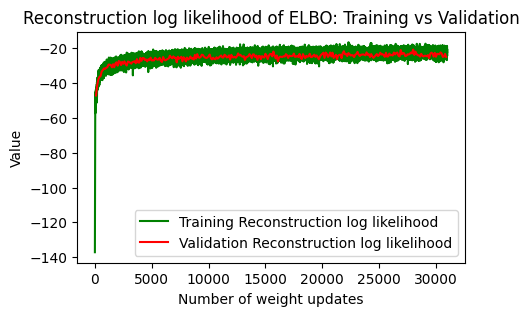

In [120]:
plt.figure(figsize=(5,3), dpi=100)
plt.plot(err_l, 'g', label='Training Reconstruction log likelihood')
plt.plot(update, [float(v) for v in testl], 'r', label='Validation Reconstruction log likelihood')
plt.title('Reconstruction log likelihood of ELBO: Training vs Validation')
plt.xlabel('Number of weight updates')
plt.ylabel('Value')
plt.legend()

In [121]:
crbm_epochs = list(range(1, 101))  # 100 epochs
#crbm_errors = np.random.normal(100, 20, 100)  # Placeholder: reconstruction error
crbm_errors = errors
crbm_free_energies_train = np.random.normal(50, 10, 100)  # Placeholder: training free energy
crbm_free_energies_val = np.random.normal(55, 10, 100)    # Placeholder: validation free energy

In [122]:
vae_epochs = list(range(1, 100))
err_l_vae = err_l
testl_vae = testl
kld_l_vae = kld_l
n_wu_vae = n_wu
update_vae = update


In [123]:
# Align VAE metrics by averaging per epoch
batches_per_epoch = len(n_wu_vae) // len(vae_epochs)  # Approx. batches per epoch
err_l_vae_per_epoch = []
kld_l_vae_per_epoch = []
for i in range(len(vae_epochs)):
    start_idx = i * batches_per_epoch
    end_idx = (i + 1) * batches_per_epoch
    err_l_vae_per_epoch.append(np.mean(err_l_vae[start_idx:end_idx]))
    kld_l_vae_per_epoch.append(np.mean(kld_l_vae[start_idx:end_idx]))

In [124]:
# Validation reconstruction log likelihood (align to epochs)
testl_vae_per_epoch = []
updates_per_epoch = len(update_vae) // len(vae_epochs)
for i in range(len(vae_epochs)):
    start_idx = i * updates_per_epoch
    end_idx = (i + 1) * updates_per_epoch
    testl_vae_per_epoch.append(np.mean([float(v) for v in testl_vae[start_idx:end_idx]]))

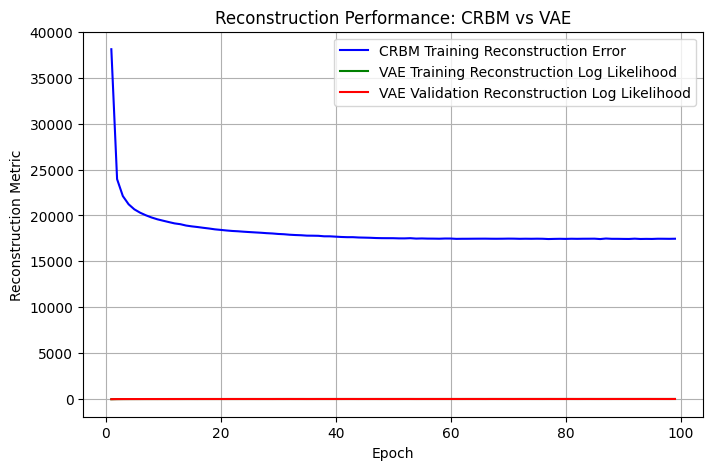

In [125]:
# Plot 1: Reconstruction Error Comparison
plt.figure(figsize=(8, 5), dpi=100)
plt.plot(crbm_epochs[:len(vae_epochs)], crbm_errors[:len(vae_epochs)], 'b-', label='CRBM Training Reconstruction Error')
'''plt.plot(vae_epochs, err_l_vae_per_epoch, 'g-', label='VAE Training Reconstruction Log Likelihood')
plt.plot(vae_epochs, testl_vae_per_epoch, 'r-', label='VAE Validation Reconstruction Log Likelihood')'''

plt.plot(vae_epochs, err_l_vae_per_epoch[:len(vae_epochs)], 'g-', label='VAE Training Reconstruction Log Likelihood')
plt.plot(vae_epochs, testl_vae_per_epoch[:len(vae_epochs)], 'r-', label='VAE Validation Reconstruction Log Likelihood')

plt.title('Reconstruction Performance: CRBM vs VAE')
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Metric')
plt.legend()
plt.grid(True)
plt.show()
plt.close()

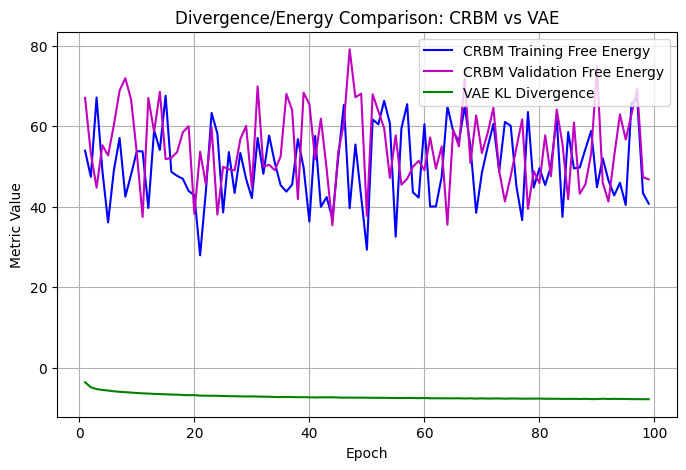

In [126]:
# Plot 2: KL Divergence vs Free Energy Comparison
plt.figure(figsize=(8, 5), dpi=100)
plt.plot(crbm_epochs[:len(vae_epochs)], crbm_free_energies_train[:len(vae_epochs)], 'b-', label='CRBM Training Free Energy')
plt.plot(crbm_epochs[:len(vae_epochs)], crbm_free_energies_val[:len(vae_epochs)], 'm-', label='CRBM Validation Free Energy')
plt.plot(vae_epochs, kld_l_vae_per_epoch, 'g-', label='VAE KL Divergence')
plt.title('Divergence/Energy Comparison: CRBM vs VAE')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()
plt.close()

In [145]:
import matplotlib.pyplot as plt
import scienceplots

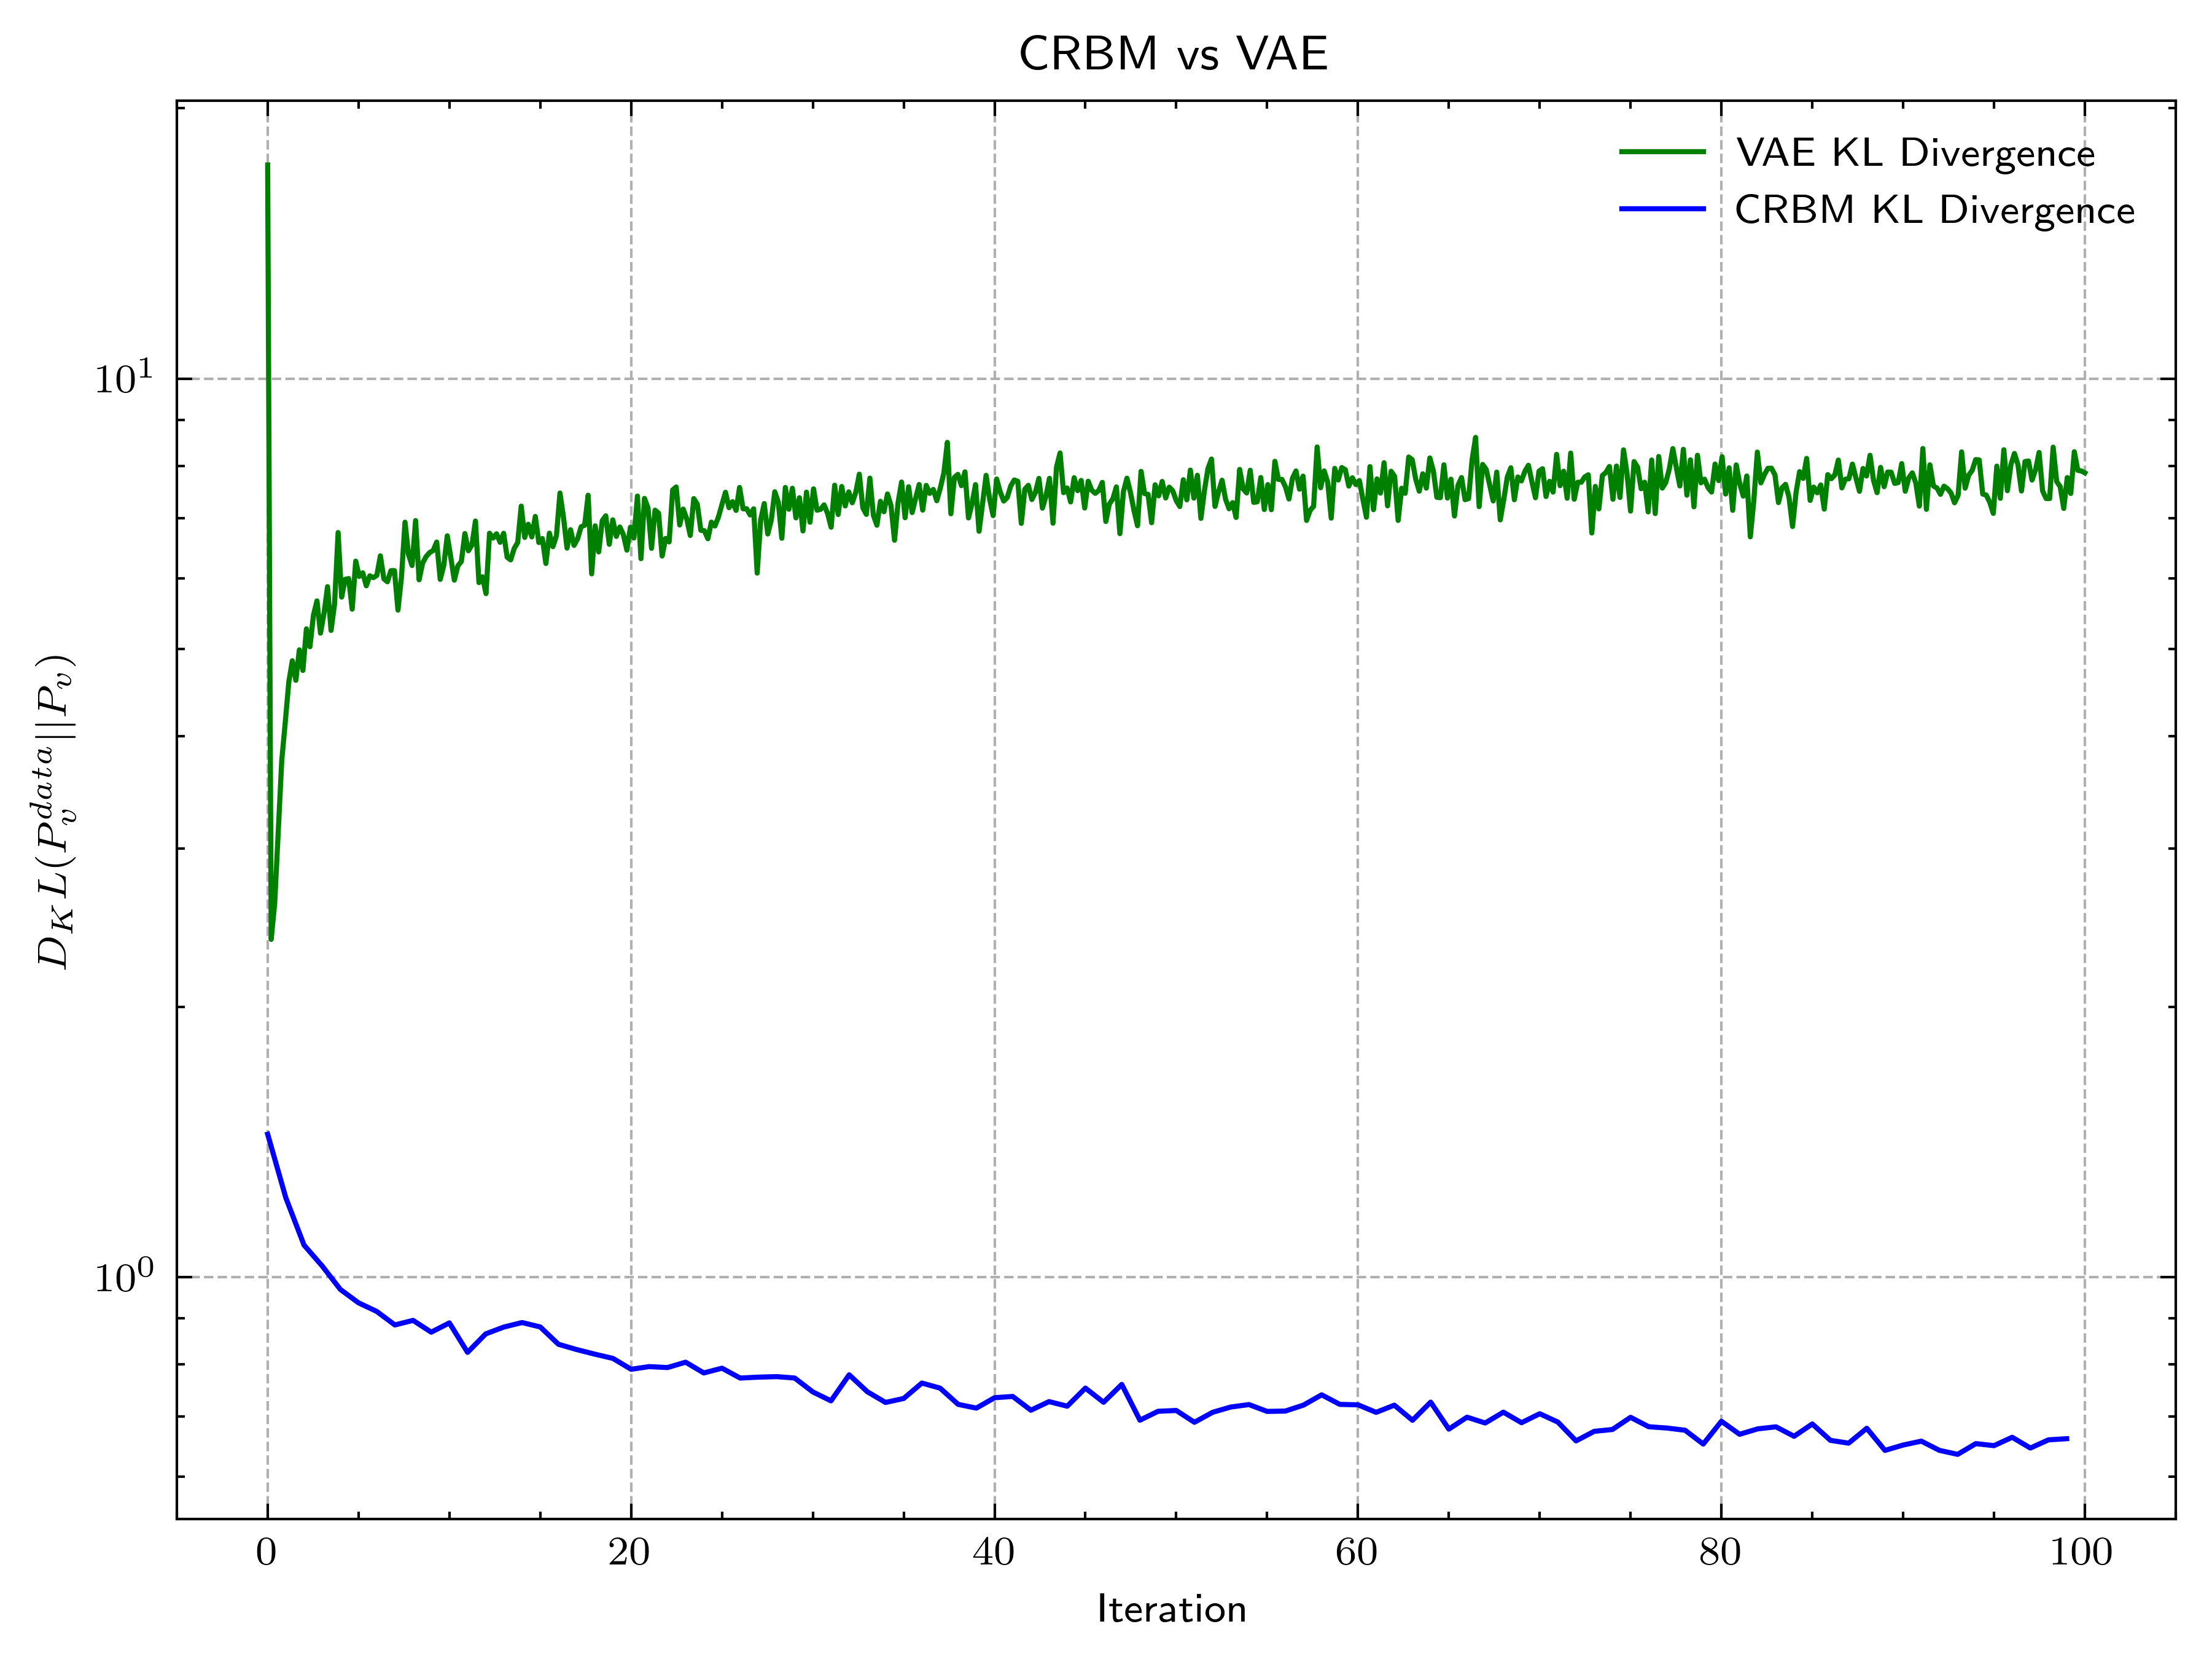

In [156]:
 with plt.style.context(['science','ieee']):
    fig, ax = plt.subplots(figsize=(7, 5))
    plt.plot(np.linspace(0,100,len(kld_l[::60])), - np.array(kld_l[::60]), 'g-', label='VAE KL Divergence')
    plt.plot(range(len(crbm_dkl_per_epoch)), (crbm_dkl_per_epoch), 'b-', label='CRBM KL Divergence')
    plt.title('CRBM vs VAE')
    plt.xlabel('Iteration')
    plt.ylabel('$D_KL(P_v^{data}||P_v)$')
    plt.yscale('log')
    plt.legend()
    ax.grid(which='major', linestyle='--', linewidth=0.5)
    #plt.savefig('DKLComparison_VAE_vs_CRBM.pdf', format='pdf', bbox_inches='tight')
    plt.savefig('DKLComparison_VAE_vs_CRBM.png')
plt.show()



In [147]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import cv2
from matplotlib.colors import LinearSegmentedColormap
import scienceplots

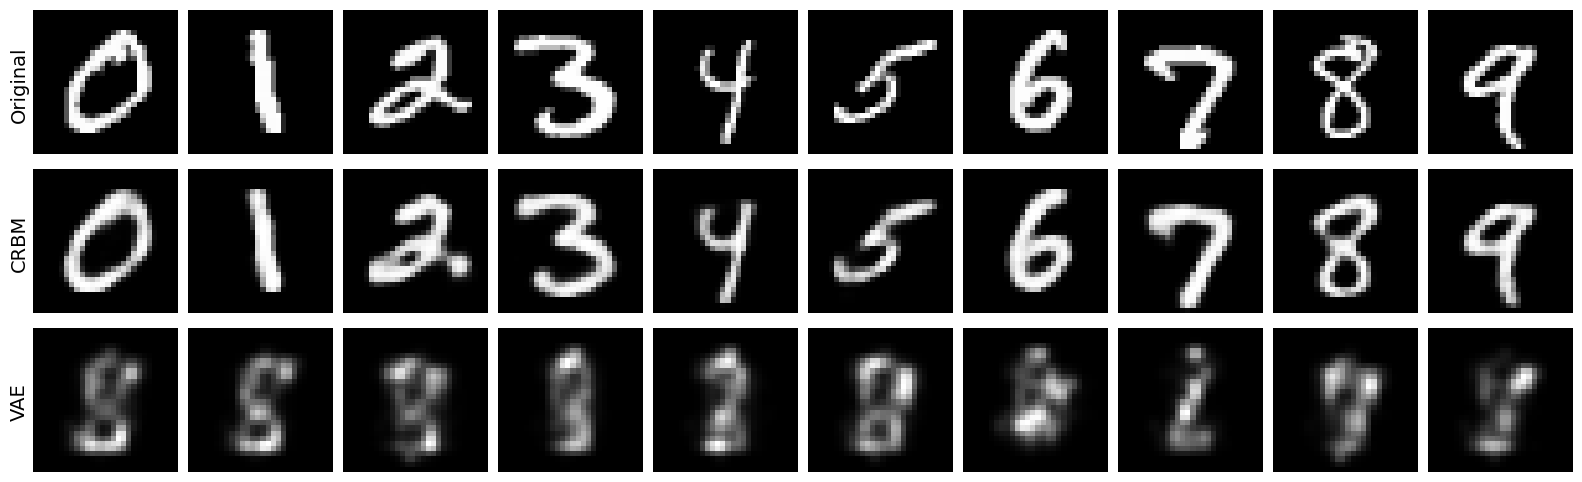

In [159]:
fig, axes = plt.subplots(3, num_samples, figsize=(2 * num_samples, 6), gridspec_kw={'wspace': 0, 'hspace': 0.1})
#fig.suptitle("CRBM Reconstruction vs VAE Reconstruction", fontsize=16)

# Add row labels
axes[0, 0].text(-5, 14, "Original", size=14, va='center', rotation=-270)
axes[1, 0].text(-5, 14, "CRBM", size=14, va='center', rotation=-270)
axes[2, 0].text(-5, 14, "VAE", size=14, va='center', rotation=-270)

vae_model.eval()

for n in range(num_samples):
    original = selected_imgs[n]

    # --- ORIGINAL ---
    axes[0, n].imshow(original.reshape(28, 28), cmap='gray')
    axes[0, n].axis('off')

    # --- CRBM RECONSTRUCTION ---
    crbm_input = original.reshape(28 * 28)
    crbm_recon = model.get_reconstruction(crbm_input).reshape(28, 28)
    axes[1, n].imshow(crbm_recon, cmap='gray')
    axes[1, n].axis('off')

    # --- VAE RECONSTRUCTION ---
    # Step 1: Resize original image to 14x14 for VAE input
    input_14 = cv2.resize(original.astype(np.float32), (14, 14), interpolation=cv2.INTER_AREA)

    # Step 2: Convert to tensor and feed into VAE
    input_tensor = torch.tensor(input_14, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)  # shape: [1, 1, 14, 14]
    input_flat = input_tensor.view(1, -1)  # shape: [1, 196]

    with torch.no_grad():
        recon, _, _ = vae_model(input_flat)  # recon is shape: [1, 196]
        recon_image = recon.view(1, 1, 14, 14)  # reshape to 14x14 image
        recon_resized = F.interpolate(recon_image, size=(28, 28), mode='bilinear').squeeze().cpu().numpy()

    axes[2, n].imshow(recon_resized, cmap='gray')
    axes[2, n].axis('off')
    #plt.savefig('CRBM_VAE_Reconstruction.pdf', format='pdf', bbox_inches='tight')
    plt.savefig('CRBM_VAE_Reconstruction.png')

plt.show()


C:\Users\nermi\AppData\Local\Temp\ipykernel_17648\4164098359.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


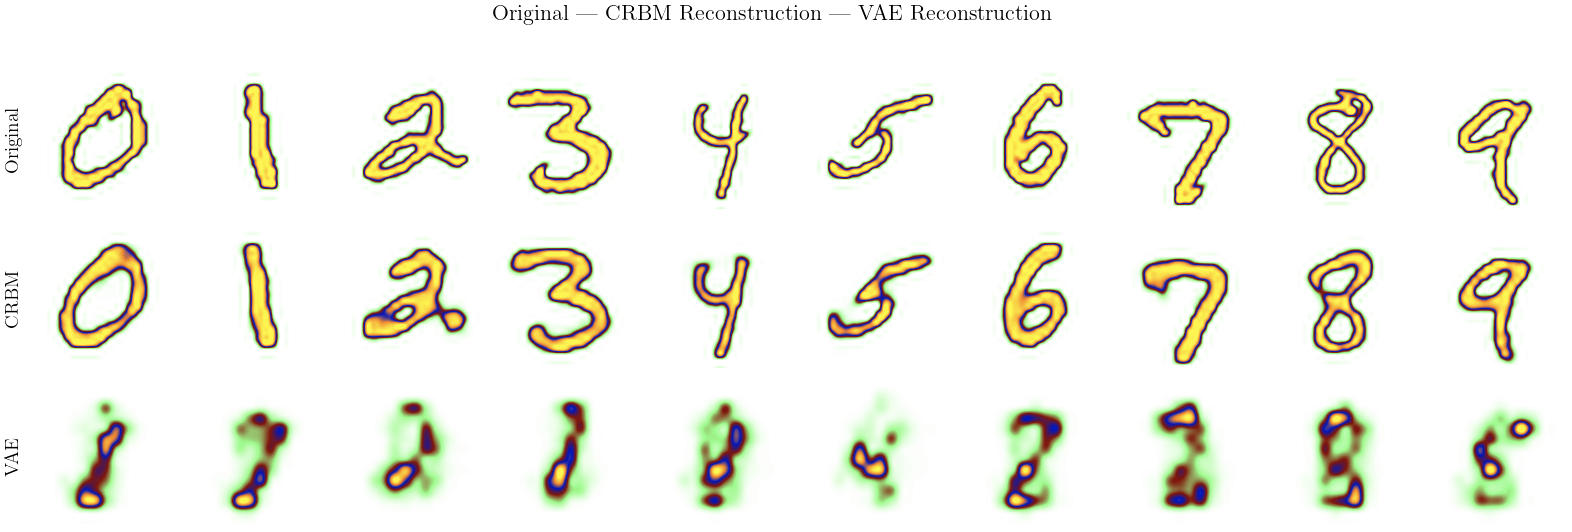

In [149]:
# Define your custom colormap
hex_colors = ['#FFFFFF', '#9FFA8E', '#7F170C', '#0018BC', '#EF8833', '#FDF551']
custom_cmap = LinearSegmentedColormap.from_list('custom_weights', hex_colors, N=256)

with plt.style.context(['science']):
    fig, axes = plt.subplots(3, num_samples, figsize=(2 * num_samples, 6), gridspec_kw={'wspace': 0, 'hspace': 0.1})
    fig.suptitle("Original | CRBM Reconstruction | VAE Reconstruction", fontsize=16)

    # Add row labels
    axes[0, 0].text(-5, 14, "Original", size=14, va='center', rotation=-270)
    axes[1, 0].text(-5, 14, "CRBM", size=14, va='center', rotation=-270)
    axes[2, 0].text(-5, 14, "VAE", size=14, va='center', rotation=-270)

    vae_model.eval()

    for n in range(num_samples):
        original = selected_imgs[n]

        # --- ORIGINAL ---
        axes[0, n].imshow(original.reshape(28, 28), cmap=custom_cmap, interpolation='lanczos')
        axes[0, n].axis('off')

        # --- CRBM RECONSTRUCTION ---
        crbm_input = original.reshape(28 * 28)
        crbm_recon = model.get_reconstruction(crbm_input).reshape(28, 28)
        axes[1, n].imshow(crbm_recon, cmap=custom_cmap, interpolation='lanczos')
        axes[1, n].axis('off')

        # --- VAE RECONSTRUCTION ---
        # Step 1: Resize to 14x14 using OpenCV
        input_14 = cv2.resize(original.astype(np.float32), (14, 14), interpolation=cv2.INTER_AREA)

        # Step 2: Convert to tensor for the model
        input_tensor = torch.tensor(input_14).unsqueeze(0).unsqueeze(0).to(device).float()  # [1, 1, 14, 14]
        input_flat = input_tensor.view(1, -1)  # Flatten to [1, 196]

        # Step 3: Inference and reshape output
        with torch.no_grad():
            recon, _, _ = vae_model(input_flat)
            recon_14 = recon.view(1, 1, 14, 14)
            recon_resized = F.interpolate(recon_14, size=(28, 28), mode='bilinear').squeeze().cpu().numpy()

        axes[2, n].imshow(recon_resized, cmap=custom_cmap, interpolation='lanczos')
        axes[2, n].axis('off')

    plt.tight_layout()
    fig.subplots_adjust(top=0.88)
    plt.show()
